## Importing Libs

**Disclamer**: the presented code is not a high optimal and there's definitely some space for refactoring

In [ ]:
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

## Small EDA & data cleaning

First of all we need to do a quick check in the data and remove the outliers.

In [ ]:
df = pd.read_csv('/content/robotex4.csv')
df.start_time = pd.to_datetime(df.start_time)  
df

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-11 03:20:51.446343,59.435092,24.746192,59.413620,24.669301,1.221750
1,2022-03-21 18:51:11.394013,59.440585,24.704871,59.448580,24.695094,0.260000
2,2022-03-23 06:44:57.844104,59.424660,24.736591,59.414483,24.816408,1.142750
3,2022-03-26 14:42:25.716000,59.424239,24.724754,59.401068,24.644707,1.280845
4,2022-03-09 08:10:41.153870,59.436079,24.732235,59.397603,24.680948,1.283000
...,...,...,...,...,...,...
660216,2022-03-25 12:39:59.295086,59.417072,24.799048,59.405560,24.706132,1.328000
660217,2022-03-03 13:45:37.653168,59.440089,24.729332,59.434221,24.823899,1.322000
660218,2022-03-04 12:02:42.630196,59.370844,24.668771,59.406154,24.704330,1.097000
660219,2022-03-04 07:27:50.955369,59.489902,24.933111,59.400403,24.825276,2.899250


Let's analyze the ride_value column.

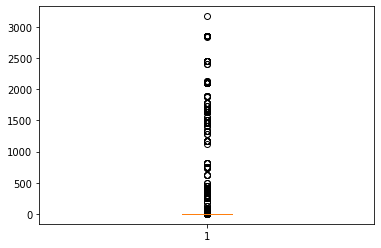

In [ ]:
plt.boxplot(df['ride_value'])
plt.show()

Alright, that seems to be too much for the outliers. I will remove every row with ride_value > 15 (seems to be reasonable for Tallinn)

In [ ]:
print(f"Rows with ride_value > 15: {sum(df['ride_value'] > 15)}")
df = df[df['ride_value'] <= 15]

Rows with ride_value > 15: 725


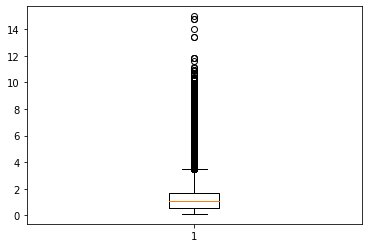

In [ ]:
plt.boxplot(df['ride_value'])
plt.show()

Okay, now it seems to be better. Let's take a look on a date iterval.

In [ ]:
print(f"First date: {min(df['start_time'])}")
print(f"Last date: {max(df['start_time'])}")

First date: 2022-03-01 00:00:07.936317
Last date: 2022-03-28 23:59:54.440558


We have less than a month period. This means that we will use only hours & weekdays.

But what about the coordinates? Are all of the rides were started and ended in Tallinn? 

The following screenshot & Tallinn's border coordinates are taken from [here](http://apps.headwallphotonics.com/)

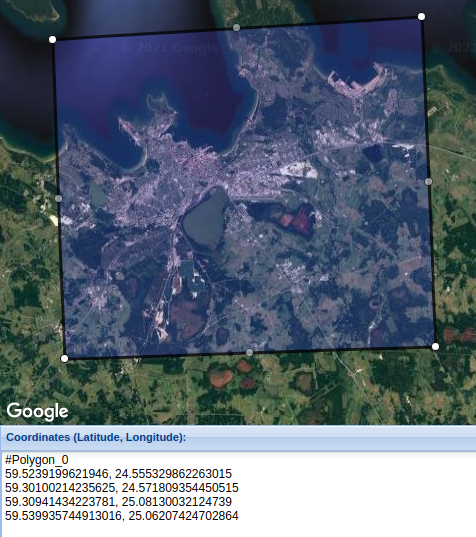

In [ ]:
# Taking only top-left & bottom-right coords
Tallin_border = ((59.5239199621946, 24.555329862263015), (59.30941434223781, 25.08130032124739))

start_filter = ~((df['start_lat'] >= Tallin_border[1][0]) & (df['start_lng'] >= Tallin_border[0][1]) & (df['start_lat'] <= Tallin_border[0][0]) & (df['start_lng'] <= Tallin_border[1][1]))
end_filter = ~((df['end_lat'] >= Tallin_border[1][0]) & (df['end_lng'] >= Tallin_border[0][1]) & (df['end_lat'] <= Tallin_border[0][0]) & (df['end_lng'] <= Tallin_border[1][1]))

print(f'There are {df[start_filter | end_filter].shape[0]} rides that started/finished out of the border')

df = df[~(start_filter | end_filter)]

There are 10539 rides that started/finished out of the border


## Data processing

To assign a driver to a specific district, we have to derive from given coordinates from which district each ride started and in which ended.

In a perfect situation, I would use all 84 subdistricts of Tallinn, but it took too much time to prepare the areas dataset.

I used the QGIS app to visualize and extract the information but did not figure out how to convert the coordinates to the right system during the time I had for this task.

The next picture is the visualization of Tallinn's subdistricts borders from QGIS. The shape file was taken from [here](https://www.tallinn.ee/est/geoportaal/Andmed).

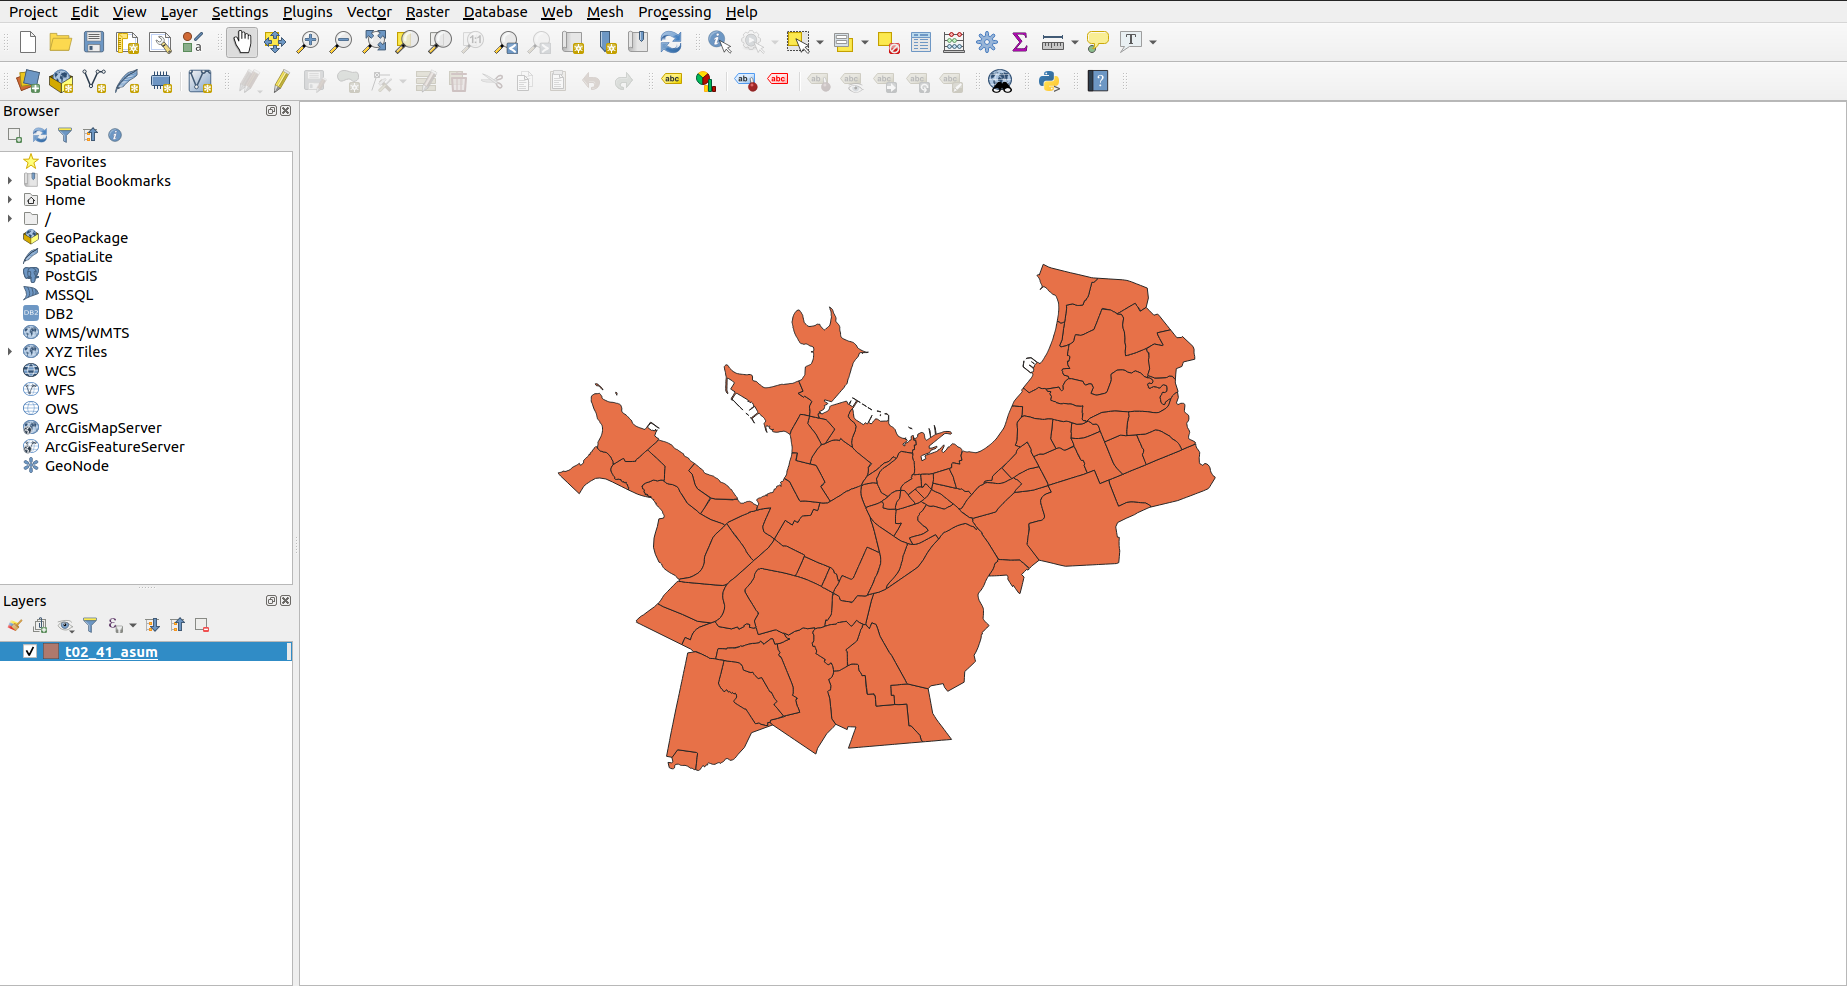

I decided to take the coordinates of the 8 districts of Tallinn, then assign a start & end districts for each ride finding the closest district by computing the distances.

This solution is not the best but I didn't have the border coordinates for the districts.

The coordinates were taken from [here](https://latitude.to/map/ee/estonia/cities/tallinn#gmapz).

The following image represents Tallinn districts map.

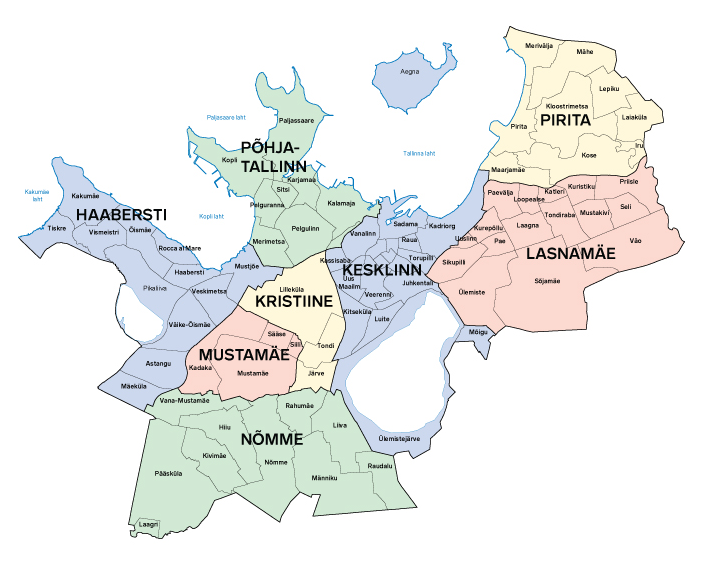

In [ ]:
distr_coord_dict = {
    "Haabersti": (59.42772, 24.64494),
    "Mustamae": (59.40036, 24.68374),
    "Noome": (59.38485, 24.68749),
    "Kristiine": (59.41703, 24.71163),
    "Pohja-Tallinn": (59.45034, 24.70457),
    "Kesklinn": (59.42814, 24.76063),
    "Lasnamae": (59.43546, 24.85250),
    "Pirita": (59.47189, 24.85439)
}


def assign_districts(df):
  distr = {'start': [], 'end':[]}

  for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    for direction in ['start', 'end']:

      min_dist = np.inf
      closest_distr = ''

      for key, value in distr_coord_dict.items():
        
        dist = geopy.distance.vincenty((row[f'{direction}_lat'], row[f'{direction}_lng']), value).km

        if dist < min_dist:
          min_dist = dist
          closest_distr = key

      distr[direction].append(closest_distr)
  
  df['start_distr'] = distr['start']
  df['end_distr'] = distr['end']
  df.sort_values('start_time', inplace=True)
  df.reset_index(inplace=True)
      

def preprocess_data(df):
  result_df = pd.DataFrame()

  for key, _ in distr_coord_dict.items():
    distr_df = df[df.start_distr == key]
    gb = distr_df[['start_time', 'ride_value']].groupby(pd.Grouper(key='start_time', freq='60Min', label='left'))
    distr_df = gb.size().to_frame(name='rides_count').join(gb.agg({'ride_value': 'sum'}).rename(columns={'ride_value': 'rides_values_sum'})).reset_index()
    distr_df['start_distr'] = key

    result_df = pd.concat([result_df, distr_df], ignore_index=True)

  result_df['weekday'] = result_df['start_time'].dt.dayofweek
  result_df['hour'] = result_df['start_time'].dt.hour
  result_df = result_df.drop('start_time',axis = 1)

  one_hot = pd.get_dummies(result_df['start_distr'])
  oh_enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
  oh_enc.fit(df['start_distr'].to_numpy().reshape(-1, 1))
  result_df = result_df.drop('start_distr', axis = 1)
  result_df = result_df.join(one_hot)

  return result_df, oh_enc

Assigning districts.

In [ ]:
assign_districts(df)
df

The data processing stage consist of the following steps:

* Group the data by 1 hour time interval
* Count the amount of rides started for each of the start districts
* Calculate the sum of rides for each of the time itervals and start districts
* One-hot encode the start district column 
* Add weekday & hour columns 

In [ ]:
processed_df, oh_enc = preprocess_data(df)
processed_df

,rides_count,rides_values_sum,weekday,hour,Haabersti,Kesklinn,Kristiine,Lasnamae,Mustamae,Noome,Pirita,Pohja-Tallinn
0,24,40.656750,1,0,1,0,0,0,0,0,0,0
1,26,51.459000,1,1,1,0,0,0,0,0,0,0
2,20,28.874000,1,2,1,0,0,0,0,0,0,0
3,14,25.430500,1,3,1,0,0,0,0,0,0,0
4,12,18.890500,1,4,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5371,39,97.507966,0,19,0,0,0,0,0,0,1,0
5372,56,134.731832,0,20,0,0,0,0,0,0,1,0
5373,45,117.076678,0,21,0,0,0,0,0,0,1,0
5374,42,103.756207,0,22,0,0,0,0,0,0,1,0


The final step of the data processing is to separate the dataset into test and train.

We are going to predict the expected **ride_values_sum** by teaching the model on the following data:

* last hour rides count
* weekday
* hour
* start disctrict

The idea is to find the most profitable ride start location by giving the model the information listed above from each district. After we receive the predicted ride_values_sum for each of the districts, we can select the district that will most probably bring the highest income.

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(processed_df, test_size=0.2)
train_X = train.loc[:, train.columns != 'rides_values_sum'].to_numpy()
train_y = train.loc[:, 'rides_values_sum'].to_numpy()
test_X = test.loc[:, test.columns != 'rides_values_sum'].to_numpy()
test_y = test.loc[:, 'rides_values_sum'].to_numpy()

## Model training

I have selected 2 baseline models to conduct experiments on:

1. Random Forest Regressor
2. XGBoost

The following functions train models, try to find the best hyperparameters, and calculate the MSE errors for both train and test sets.

In [ ]:
def RF_train(train_data, train_true, test_data, test_true):
    hyper_parameter = {"max_depth":[1, 2, 3, 4], "n_estimators": [40, 80, 150, 600]}
    model = RandomForestRegressor(n_jobs = -1)
    best_parameter = GridSearchCV(model, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_data, train_true)
    estimators = best_parameter.best_params_["n_estimators"]
    
    model = RandomForestRegressor(n_estimators = estimators, n_jobs = -1)
    model.fit(train_data, train_true)
    train_pred = model.predict(train_data)
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = model.predict(test_data)
    test_MSE = mean_squared_error(test_true, test_pred)
    
    return model, train_MSE, test_MSE


def XGB_train(train_data, train_true, test_data, test_true):
    hyper_parameter = {"max_depth":[1, 2, 3, 4], "n_estimators":[40, 80, 150, 600]}
    model = xgb.XGBRegressor()
    best_parameter = GridSearchCV(model, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_data, train_true)
    estimators = best_parameter.best_params_["n_estimators"]
    depth = best_parameter.best_params_["max_depth"]
    
    model = xgb.XGBRegressor(max_depth = depth, n_estimators = estimators)
    model.fit(train_data, train_true)
    train_pred = model.predict(train_data)
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = model.predict(test_data)
    test_MSE = mean_squared_error(test_true, test_pred)
    
    return model, train_MSE, test_MSE

In [ ]:
rf_model, trainMSE_rf, testMSE_rf = RF_train(train_X, train_y, test_X, test_y)
xgb_model, trainMSE_xgb, testMSE_xgb = XGB_train(train_X, train_y, test_X, test_y)

In [ ]:
metrics_df = pd.DataFrame(columns = ["model", "train_MSE", "test_MSE"])
metrics_df = metrics_df.append(pd.DataFrame([["Random Forest Regression", trainMSE_rf, testMSE_rf]], columns=metrics_df.columns))
metrics_df = metrics_df.append(pd.DataFrame([["XGBoost", trainMSE_xgb, testMSE_xgb]], columns=metrics_df.columns))

In [ ]:
metrics_df

,model,train_MSE,test_MSE
0,Random Forest Regression,16.364800,114.217882
0,XGBoost,63.152142,102.996481


#### From the above result we have following observations:

* The difference between train error and test error of random forest regressor is high, which clearly shows that random forest regressor is overfitting.
* The best model with lowest test error is XGBoost Regressor.

## Inference


In [ ]:
def predict_value_per_district(model, weekday, hour, rides_district_dict):
  distr_value_predict = {}

  for distr, rides in rides_district_dict.items():
    item = [rides, weekday, hour] + np.squeeze(oh_enc.transform([[distr]])).tolist()
    distr_value_predict[distr] = model.predict([item])[0]
  
  return distr_value_predict

In [ ]:
# Example input
rides_district_dict = {
    "Haabersti": 72,
    "Mustamae": 110,
    "Noome": 80,
    "Kristiine": 140,
    "Pohja-Tallinn": 73,
    "Kesklinn": 350,
    "Lasnamae": 120,
    "Pirita": 90
}

preds = predict_value_per_district(xgb_model, 0, 12, rides_district_dict)
preds = dict(sorted(preds.items(), key=lambda item: item[1], reverse=True))

for distr, pred in preds.items():
  print(f"{distr}: \t\t {pred}")

Kesklinn: 		 328.5572204589844
Pirita: 		 204.6591796875
Lasnamae: 		 203.10658264160156
Mustamae: 		 157.02015686035156
Noome: 		 146.57147216796875
Kristiine: 		 143.8377685546875
Haabersti: 		 119.7257080078125
Pohja-Tallinn: 		 77.9453353881836


Predicted top-3 districts for Monday, 1 PM are: **Kesklinn**, **Pirita**, **Lasnamae**

## Deployment

For this kind of task, I would use **Amazon EC2 instance** as a constantly running service, receiving requests, queueing them, running the model and giving back results via API.

It is also possible to apply other kinds of approaches like **AWS Lambda** or **AWS batch jobs** but we should know the scale of the operations and understand the possible ways of communication with other Bolt services.

## A/B testing

First of all, we need to find or create a metric that we would create a hypothesis. It could be the number of rides, general income from the operations, user feedback score, or a combination of these or other metrics.

Next thing is to define ${H_1}$ & ${H_0}$ using the metric that we found/created.

Then we separate users into control & test groups and perform the A/B testing.

Finally, we conduct significance testing and find out if the new approach is working better than the one that is currently used. 

### Thank you for your time and have a great day!